improting the libraries 

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import auc

import tensorflow as tf
import keras

from sklearn.preprocessing import StandardScaler

from keras.layers import Dropout
from keras import regularizers
from keras.callbacks import ModelCheckpoint


import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , roc_curve


2023-10-06 09:56:56.361519: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-06 09:57:01.375386: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-06 09:57:01.386624: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 09:57:19.088498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [53]:
from sklearn.decomposition import PCA
import time
import datetime
cur_time  = datetime.datetime.now().strftime('%m -%d %H:%M')




# funtions 

In [60]:
def neural_net(X_train_scaled , y_train , PLOT = False , num_epochs = 80 , input_shape =12 , train = True):
    # Build the neural network
    model = keras.Sequential([
        keras.layers.Dense(256, activation='relu', input_shape=(input_shape,), kernel_regularizer=regularizers.l2(0.01)),
        keras.layers.Dropout(0.4),  # Dropout layer with a 50% dropout rate
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.4),  # Dropout layer with a 50% dropout rate
        keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer=keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint('best_model_{}_{}.h5'.format(num_epochs ,datetime.datetime.now().strftime('%m -%d %H:%M')),
                                  monitor='val_loss',
                                  save_best_only=True)

    # Training
    if train :
        history = model.fit(X_train_scaled, y_train, epochs=num_epochs, batch_size=32, validation_split=0.2 ,  callbacks=[checkpoint])
    else:
        
        return print((model.summary()))
    if PLOT:
        training_loss = history.history['loss']
        training_accuracy = history.history['accuracy']
        validation_loss = history.history['val_loss']
        validation_accuracy = history.history['val_accuracy']

        # Plot the training and validation loss
        plt.plot(training_loss, label='Training Loss')
        plt.plot(validation_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Plot the training and validation accuracy
        plt.plot(training_accuracy, label='Training Accuracy')
        plt.plot(validation_accuracy, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

   
    return model
    

def pca_trans(X_train , X_test , n_comp = 12):
   
    shape_1 = X_train.shape
    pca = PCA(n_components=n_comp)
    pca = pca.fit(X_train)

    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    shape_2 = X_train_pca.shape
    print (f"INPUT DATA SHAPE WAS {shape_1}  final shape = {shape_2}")
    return X_train_pca , X_test_pca
def Scaler(new_data , ratio = 9000):
    train_data = new_data[:ratio]
    test_data = new_data[ratio:]
    train_data_val = train_data.pop('Exited')
    test_data_val = test_data.pop("Exited")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_data.to_numpy())
    Y_train = train_data_val.to_numpy()
    X_test_scaled = scaler.fit_transform(test_data.to_numpy())
    Y_test = test_data_val.to_numpy()
    return X_train_scaled , Y_train , X_test_scaled , Y_test


def save( X_test_pca ,Y_test  ):
# Reshape Y_test to have shape (1000, 1)
    Y_test = Y_test.reshape(-1, 1)

    # Create a Pandas DataFrame
    df = pd.DataFrame(np.hstack((X_test_pca, Y_test)), columns=['Feature_{}'.format(i) for i in range(X_test_pca.shape[1])] + ['Y Value'])

    # Save the DataFrame to a CSV file
    df.to_csv('test_data.csv', index=False)


def compute_metrics(y_pred ,Y_test ):
   
    fpr, tpr, thresholds = roc_curve(Y_test, y_pred)

    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
    ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
    print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

    auc_value = auc(fpr, tpr)
    print("Area under curve, AUC = ", auc_value)
    thresh = float(input("ENter threshold:  "))
    y_pred_binary = y_pred >= thresh
    cm = confusion_matrix(Y_test, y_pred_binary)
    print (cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

   
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'y--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()


    plt.show()



In [3]:
path = input ("Path to the data: ")
data = pd.read_csv(path)

INPUT DATA SHAPE WAS (9000, 2947)  final shape = (9000, 12)
Epoch 1/3
225/225 [==============================] - 5s 13ms/step - loss: 1.0243 - accuracy: 0.7897 - val_loss: 0.6627 - val_accuracy: 0.7894
Epoch 2/3
225/225 [==============================] - 2s 11ms/step - loss: 0.5807 - accuracy: 0.7947 - val_loss: 0.5166 - val_accuracy: 0.7900
Epoch 3/3
225/225 [==============================] - 3s 11ms/step - loss: 0.5041 - accuracy: 0.7954 - val_loss: 0.4830 - val_accuracy: 0.7894


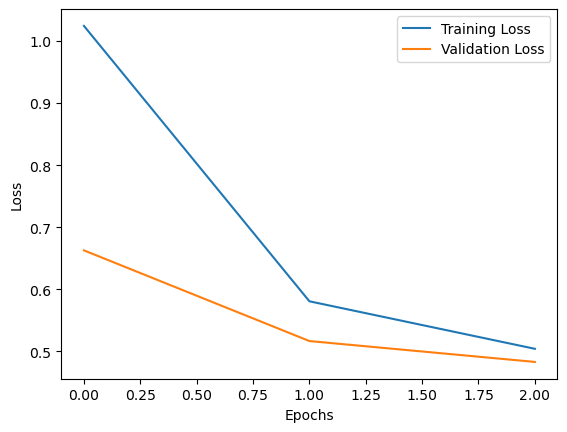

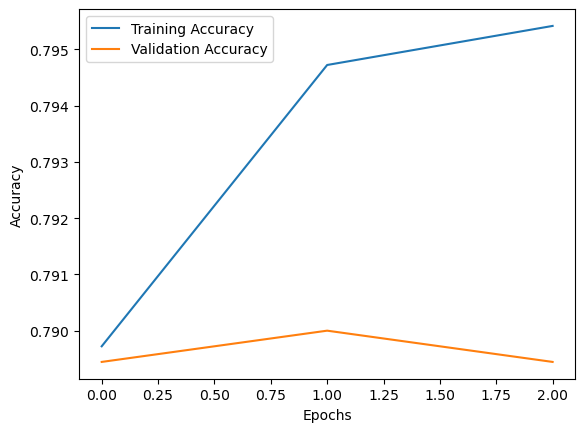

32/32 [==============================] - 0s 6ms/step - loss: 0.4511 - accuracy: 0.8210
Accuracy =  82.09999799728394 %


In [55]:
## encode the columns
full_data = data.copy()
full_data = pd.get_dummies(full_data)

## scla the data 
X_train , Y_train , X_test  , Y_test = Scaler(full_data)

## dimensionality reduction

X_train_pca , X_test_pca = pca_trans(X_train , X_test , n_comp = 12)


## create the model 
model = neural_net(X_train_pca , Y_train , train = True , PLOT = True, num_epochs = 3 , input_shape = 12)


## evaluating  the model 

_, acc = model.evaluate(X_test_pca, Y_test)
print("Accuracy = ", (acc * 100.0), "%")



Epoch 1/6
225/225 [==============================] - 5s 12ms/step - loss: 1.0340 - accuracy: 0.7931 - val_loss: 0.6877 - val_accuracy: 0.7894
Epoch 2/6
225/225 [==============================] - 3s 12ms/step - loss: 0.5925 - accuracy: 0.7947 - val_loss: 0.5255 - val_accuracy: 0.7894
Epoch 3/6
225/225 [==============================] - 2s 10ms/step - loss: 0.5070 - accuracy: 0.7949 - val_loss: 0.4873 - val_accuracy: 0.7894
Epoch 4/6
225/225 [==============================] - 3s 12ms/step - loss: 0.4858 - accuracy: 0.7969 - val_loss: 0.4783 - val_accuracy: 0.7922
Epoch 5/6
225/225 [==============================] - 2s 9ms/step - loss: 0.4753 - accuracy: 0.7968 - val_loss: 0.4675 - val_accuracy: 0.7922
Epoch 6/6
225/225 [==============================] - 2s 10ms/step - loss: 0.4688 - accuracy: 0.8015 - val_loss: 0.4648 - val_accuracy: 0.7994


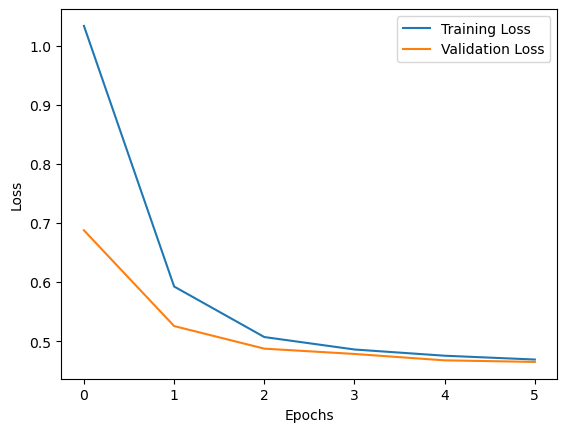

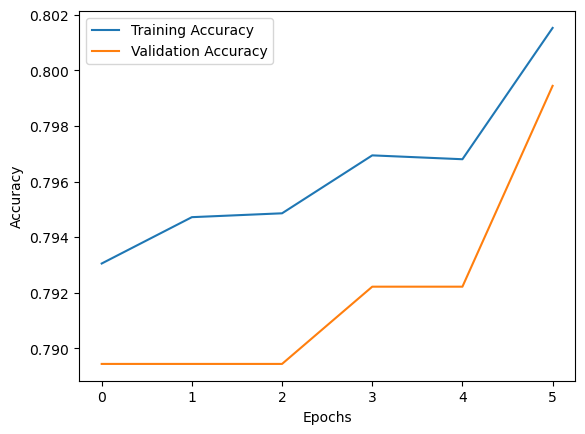

In [61]:
model = neural_net(X_train_pca , Y_train , train = True , PLOT = True, num_epochs = 6 , input_shape = 12)

In [19]:
## prediction 

y_pred = model.predict(X_test_pca)
print (y_pred)

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 4ms/step
[[0.12473725]
 [0.10189195]
 [0.14745031]
 [0.11273809]
 [0.07067528]
 [0.08486539]
 [0.11959323]
 [0.04707818]
 [0.13269617]
 [0.42810577]
 [0.51731205]
 [0.13062756]
 [0.06601997]
 [0.14743432]
 [0.17562126]
 [0.06870672]
 [0.11280528]
 [0.15789434]
 [0.2852668 ]
 [0.0514866 ]
 [0.13886489]
 [0.49435198]
 [0.03233225]
 [0.05520229]
 [0.19668797]
 [0.07214903]
 [0.16274807]
 [0.1667133 ]
 [0.20246886]
 [0.14714366]
 [0.40556645]
 [0.05766477]
 [0.08377001]
 [0.1138734 ]
 [0.17246412]
 [0.2307819 ]
 [0.1304158 ]
 [0.18788886]
 [0.39258158]
 [0.09557689]
 [0.23293614]
 [0.497243  ]
 [0.10358254]
 [0.1379682 ]
 [0.39477053]
 [0.17549853]
 [0.23099728]
 [0.23996496]
 [0.44042462]
 [0.07338419]
 [0.2167378 ]
 [0.39799526]
 [0.5362478 ]
 [0.08742053]
 [0.10647447]
 [0.24833497]
 [0.43399516]
 [0.15265067]
 [0.14743203]
 [0.14416942]
 [0.10540693]
 [0.11186965]
 [0.16993317]
 [0.1212578 ]
 [0.5743812 ]
 [0.07820276]
 [0.09827039]
 [0.14059

In [8]:


fpr, tpr, thresholds = roc_curve(Y_test, y_pred)

i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 




Ideal threshold is:  155    0.197999
Name: thresholds, dtype: float32


Ideal threshold is:  155    0.197999
Name: thresholds, dtype: float32
Area under curve, AUC =  0.78036731333229
[[588 233]
 [ 51 128]]


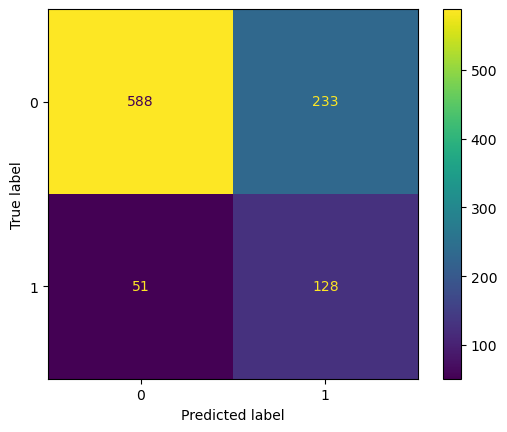

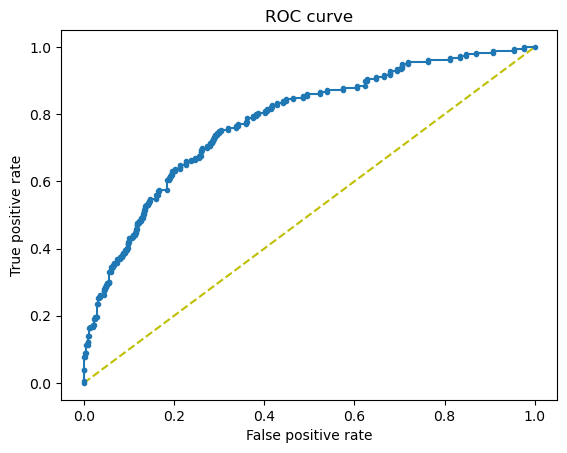

In [9]:
mythreshold=    float(input("Enter the thresh hold: "))
compute_metrics(y_pred , Y_test , mythreshold)

In [10]:
from sklearn.linear_model import LogisticRegressionCV


model = LogisticRegressionCV()

model.fit(X_train_pca , Y_train)

LogisticRegressionCV()

In [13]:
y_pred = model.predict(X_test_pca)



Ideal threshold is:  1    1
Name: thresholds, dtype: int64
Area under curve, AUC =  0.5103124000571588
[[815   6]
 [174   5]]


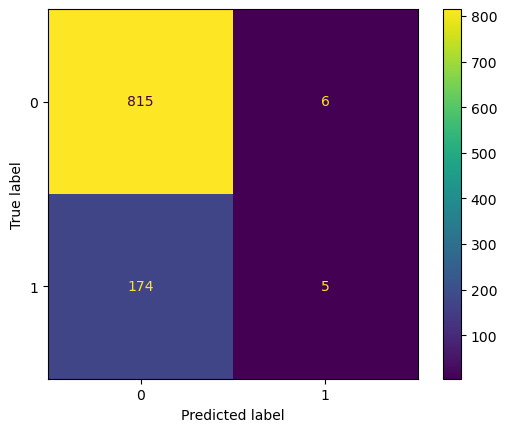

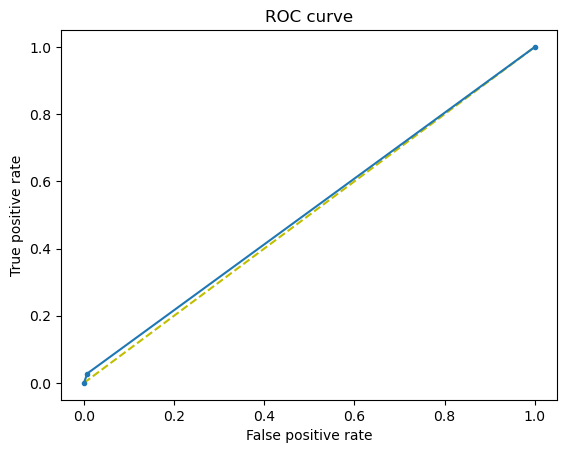

In [14]:
compute_metrics (y_pred , Y_test)